# Curso 'Modelado y aprendizaje no supervisado'

## Trabajo Práctico Final
Luego de un extenso recorrido hemos llegado al TP Final del último curso! Felicitaciones por haber llegado al último escalón de esta serie! Solo queda un paso más...

En este TP el objetivo será realizar un agrupamiento de los clientes de una empresa para entender mejor las distintas características que tienen y establecer estrategias de marketing personalizadas (Segmentación de clientes). Por lo que el objetivo principal es generar un análisis de clustering y poder realizar una descripción de las principales características que presentan los clientes que pertenecen a cada cluster.

El dataset que vamos a utilizar es marketing_campaign.csv. En el siguiente enlace pueden encontrar detallada la información de cada uno de los atributos que conforman este dataset.

El trabajo consistirá en tres secciones:

Preprocesado de los datos: verificar la calidad de los datos, seleccionar las variables de interés, estandarizar los datos.
Reducción de dimensionalidad: realizar un análisis de PCA sobre los datos, determinando el número de componentes principales óptimo según un criterio previamente establecido por el/la estudiante. Realizar un gráfico de puntos de los primeros componentes principales.
Clustering: Realizar k-means a partir del resultado del PCA (es decir, no lo hagan sobre los datos originales!) considerando el valor óptimo de k. Llevar a cabo un análisis de clustering con otro método según corresponda (ver más abajo). Realizar distintas medidas de validación interna y externa.

In [91]:
#importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns


In [73]:
#importo el dataset
df = pd.read_csv('marketing_campaign.csv',delimiter='\t')

In [74]:
df.shape


(2240, 29)

In [75]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## ZONA PREPROCESADO
Aquí tendrá que:

Exploración de los datos.
Chequear la calidad de los datos (esto incluye detectar si existen outliers y, en caso de que los hubiere, decidir qué hacer con ellos).
Seleccionar los atributos de interés: para los siguientes pasos solo nos van a interesar las variables numéricas! OJO que en el dataset existen variables que son solo dicotómicas (tomar valores 0 ó 1), esas variables no deben ser tenidas en cuenta para los siguientes pasos. Guarde las variables categóricas en una tabla separada ya que luego serán tenidas en cuenta para realizar validaciones externas.
Con la variable Year_Birth podría establecer la edad de los clientes, considerando que la edad aproximada será 2023 - Year_Birth.
Estandarizar los datos.

In [76]:
#examino la tabla para ver si hay valores nulos
df.isnull().sum()




ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [77]:
#relleno los valores nulos con la media
df['Income'].fillna(df['Income'].mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2240 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [78]:
#agregamos una columna con la edad de los clientes (Los datos fueron tomados en 2021,
#pero la practica pide que se agregue una columna con la edad de los clientes en 2023)
df['Age'] = 2023 - df['Year_Birth']


In [79]:
#agrego una columna que indique el numero de meses que el cliente lleva en la empresa usando la fecha de ingreso (Dt_Customer)
#tener en cuenta el formato de la fecha
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['Months_In_Company'] = (pd.to_datetime('2023-10-01') - df['Dt_Customer']).dt.days / 30
df['Months_In_Company'] = df['Months_In_Company'].astype(int)
df.head()




,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Months_In_Company
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,3,11,1,66,134
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,3,11,0,69,116
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,3,11,0,58,123
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,3,11,0,39,117
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,3,11,0,42,118


In [80]:
#creo una nueva columna que indique el dinero gastado por el cliente en la empresa
#los datos suministrados son en dos años (hasta 2021), pero vamosa suponer que
#fueron hasta 2023 (año actual)
df['Dinero_gastado'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Months_In_Company,Dinero_gastado
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,3,11,1,66,134,1617
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,3,11,0,69,116,27
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,3,11,0,58,123,776
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,3,11,0,39,117,53
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,3,11,0,42,118,422


In [81]:
#Creo otra columna denominada hijos, que indique el total de hijos que tiene el cliente
df['Hijos'] = df['Kidhome'] + df['Teenhome']
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Months_In_Company,Dinero_gastado,Hijos
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,3,11,1,66,134,1617,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,3,11,0,69,116,27,2
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,3,11,0,58,123,776,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,3,11,0,39,117,53,1
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,3,11,0,42,118,422,1


In [82]:
#Elimino las columnas que no voy a usar
df = df.drop(['Year_Birth','Dt_Customer','Kidhome','Teenhome','Complain','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Z_CostContact','Z_Revenue'], axis=1)
#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2240 non-null   float64
 4   Recency              2240 non-null   int64  
 5   MntWines             2240 non-null   int64  
 6   MntFruits            2240 non-null   int64  
 7   MntMeatProducts      2240 non-null   int64  
 8   MntFishProducts      2240 non-null   int64  
 9   MntSweetProducts     2240 non-null   int64  
 10  MntGoldProds         2240 non-null   int64  
 11  NumDealsPurchases    2240 non-null   int64  
 12  NumWebPurchases      2240 non-null   int64  
 13  NumCatalogPurchases  2240 non-null   int64  
 14  NumStorePurchases    2240 non-null   int64  
 15  NumWebVisitsMonth    2240 non-null   i

In [83]:
#Examino el dataframe con mas detalle
df.describe()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Months_In_Company,Dinero_gastado,Hijos
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,5592.159821,52247.251354,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,54.194196,123.985268,605.798214,0.950446
std,3246.662198,25037.797168,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,11.984069,6.747289,602.249288,0.751803
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000,112.000000,5.000000,0.000000
25%,2828.250000,35538.750000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,46.000000,118.000000,68.750000,0.000000
50%,5458.500000,51741.500000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,53.000000,124.000000,396.000000,1.000000
75%,8427.750000,68289.750000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,64.000000,130.000000,1045.500000,1.000000
max,11191.000000,666666.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,130.000000,136.000000,2525.000000,3.000000


Examinando las filas de valores maximos y minimos, se observa a simple vista que hay valores extraños en las columnas Income y edad. Voy a graficarlos para verlos mejor.

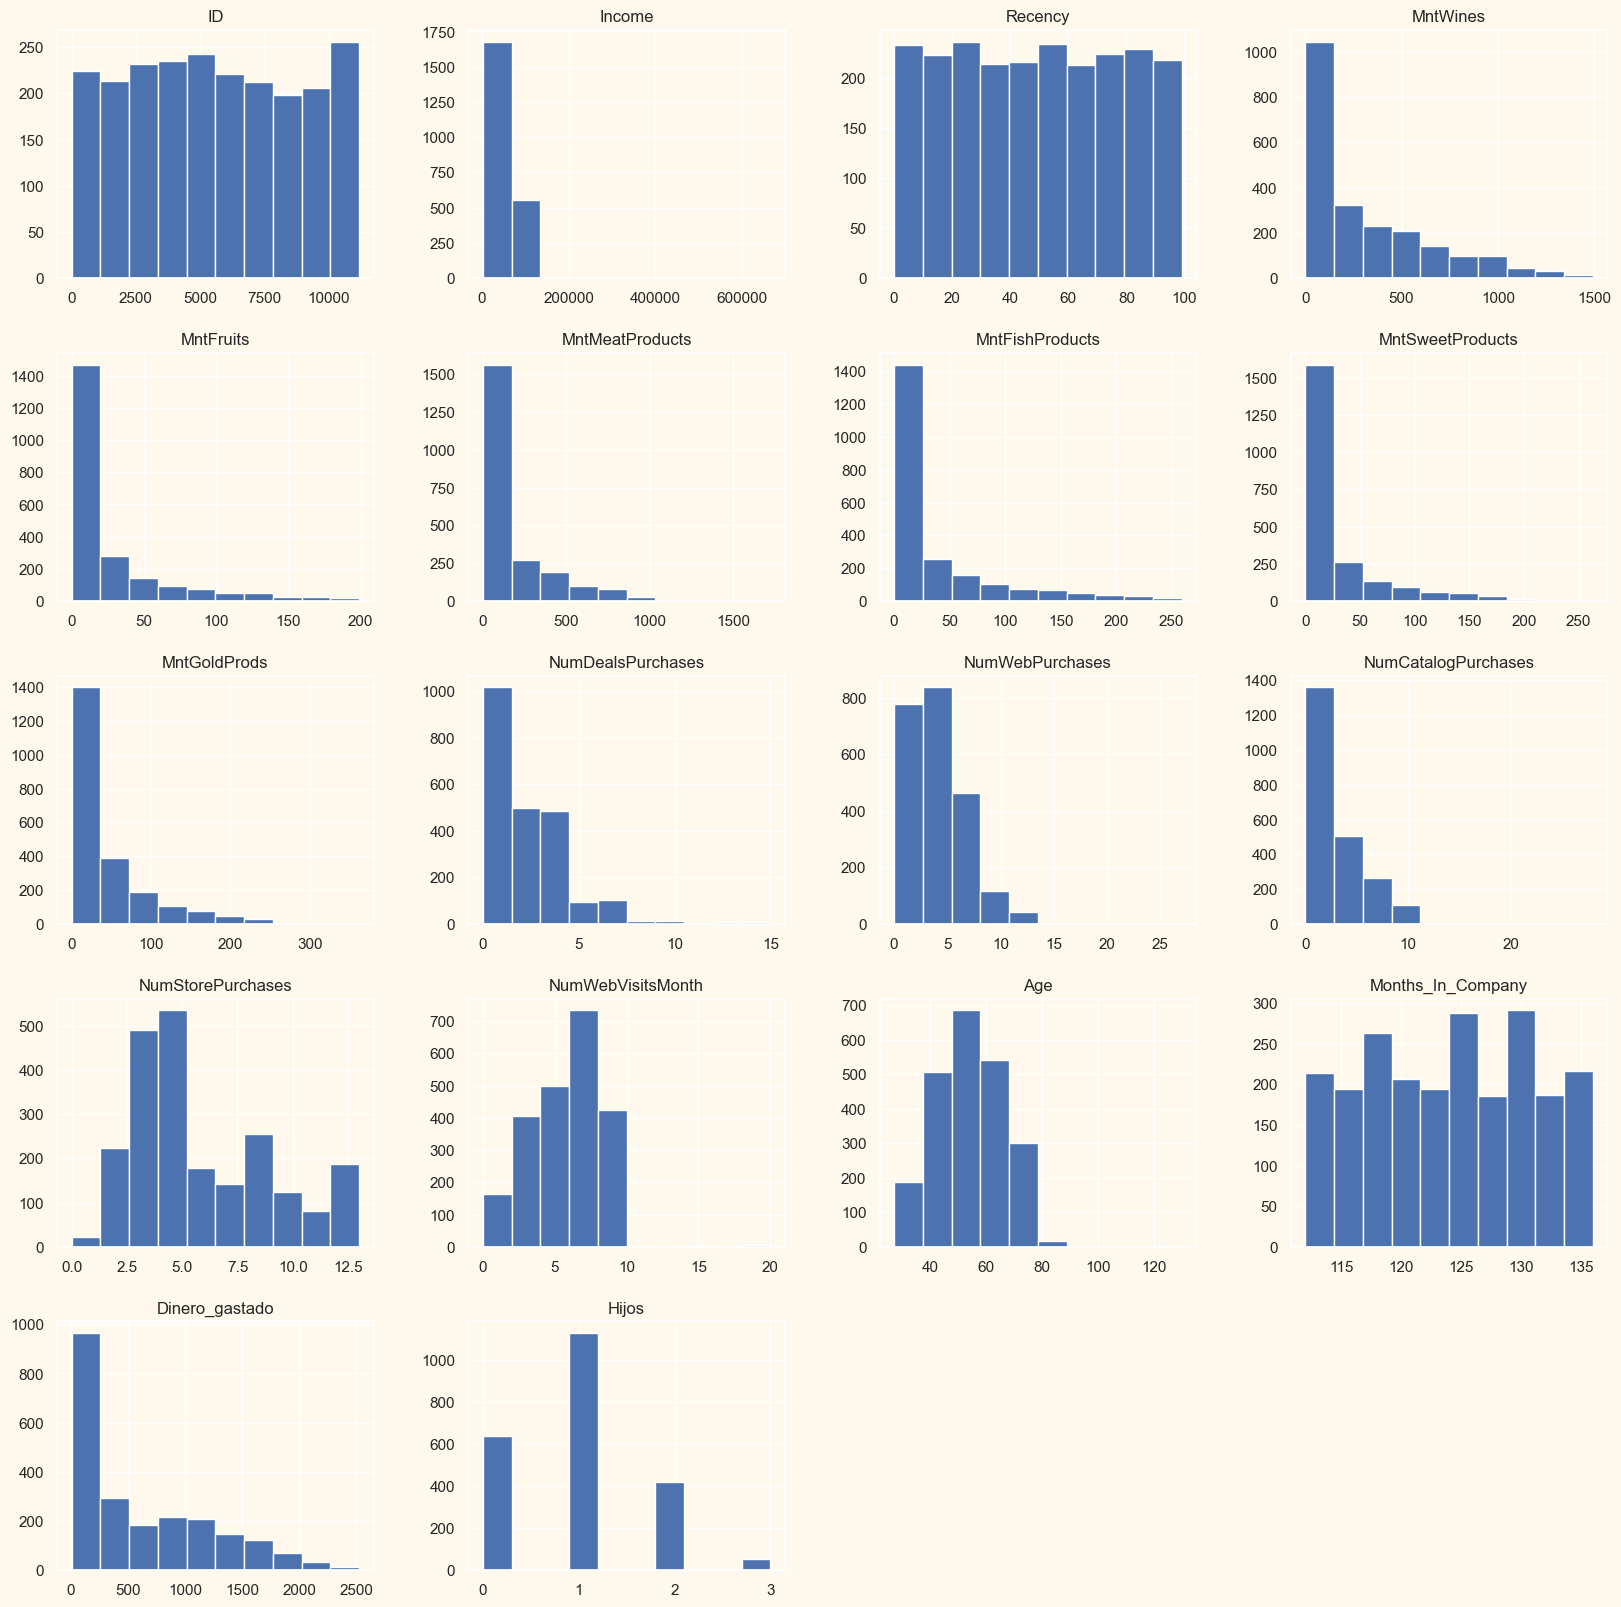

In [87]:
#grafico las variables numericas
df.hist(figsize=(20,20))
plt.show()

En estas graficas podemos ver como hay valores maximos en Income y edad, que son muy superiores a los valores medios. 

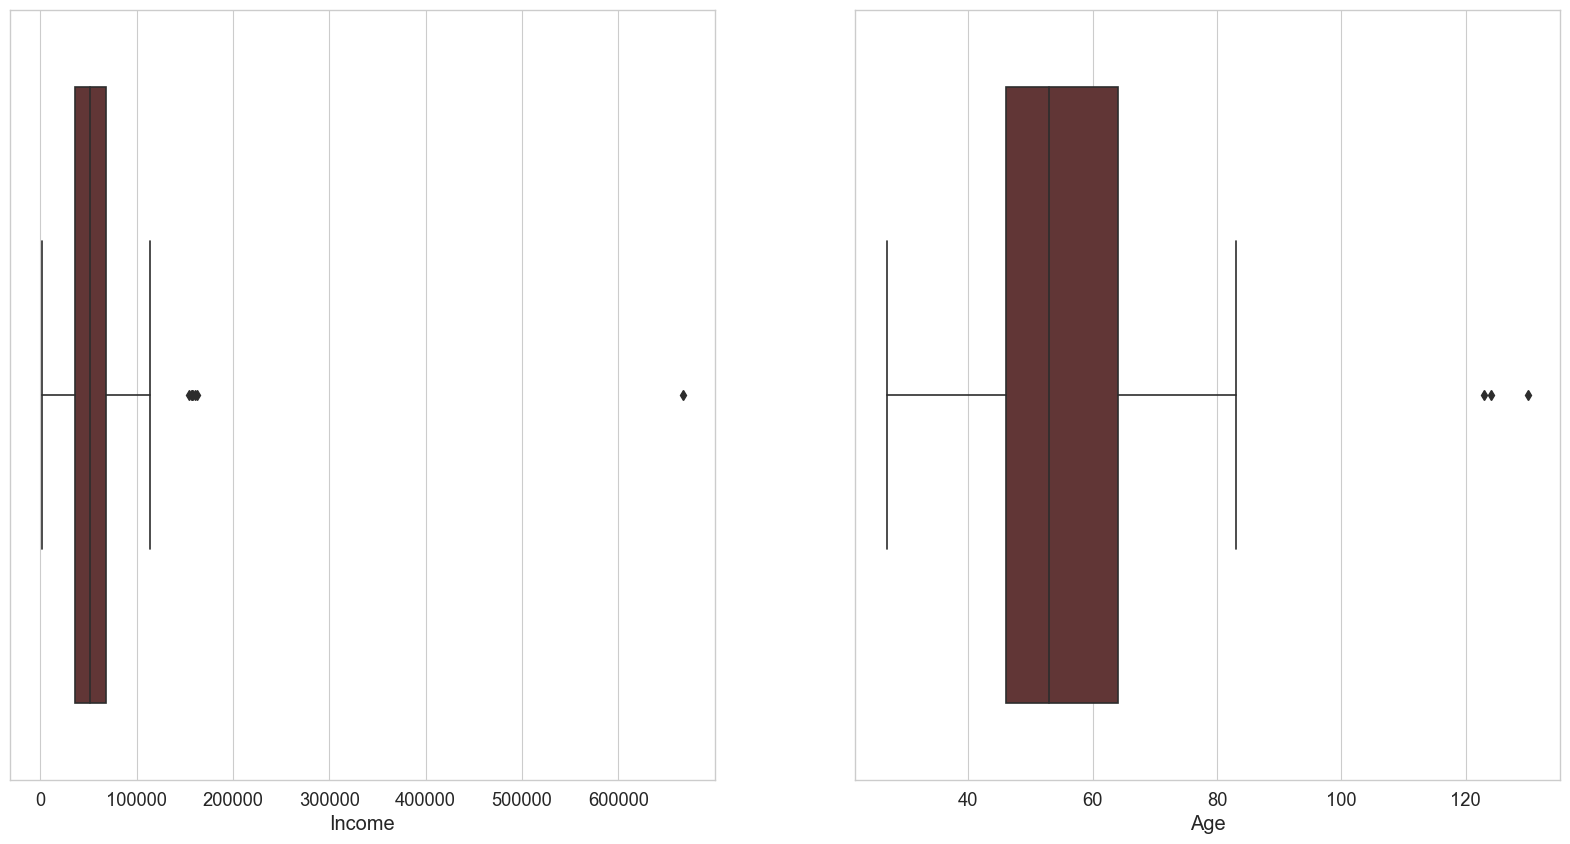

In [105]:
#Examino con mas detalle las variables con valores anormales
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(x=df['Income'], ax=ax[0])
sns.boxplot(x=df['Age'], ax=ax[1])
plt.show()


En la grafica anterior podemos observar con mayor detalle los valores atipicos de la columna Income y edad. Los eliminamos.

In [107]:
#Eliminamos los outliers en Age e Income. 
df = df[(df["Age"]<90)]
df = df[(df["Income"]<600000)]
df.shape

(2236, 20)

creare dos nuevos dataframes, uno con las variables numericas y otro con las categoricas.

In [110]:
# dataframe con las variables categoricas
df_cat = df.select_dtypes(include=['object'])
df_cat.head()


,Education,Marital_Status
0,Graduation,Single
1,Graduation,Single
2,Graduation,Together
3,Graduation,Together
4,PhD,Married


In [112]:
#dataframe con las variables numericas
df_num = df.select_dtypes(include=['float64','int32','int64'])
df_num.head()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Months_In_Company,Dinero_gastado,Hijos
0,5524,58138.0,58,635,88,546,172,88,88,3,8,10,4,7,66,134,1617,0
1,2174,46344.0,38,11,1,6,2,1,6,2,1,1,2,5,69,116,27,2
2,4141,71613.0,26,426,49,127,111,21,42,1,8,2,10,4,58,123,776,0
3,6182,26646.0,26,11,4,20,10,3,5,2,2,0,4,6,39,117,53,1
4,5324,58293.0,94,173,43,118,46,27,15,5,5,3,6,5,42,118,422,1


<Axes: >

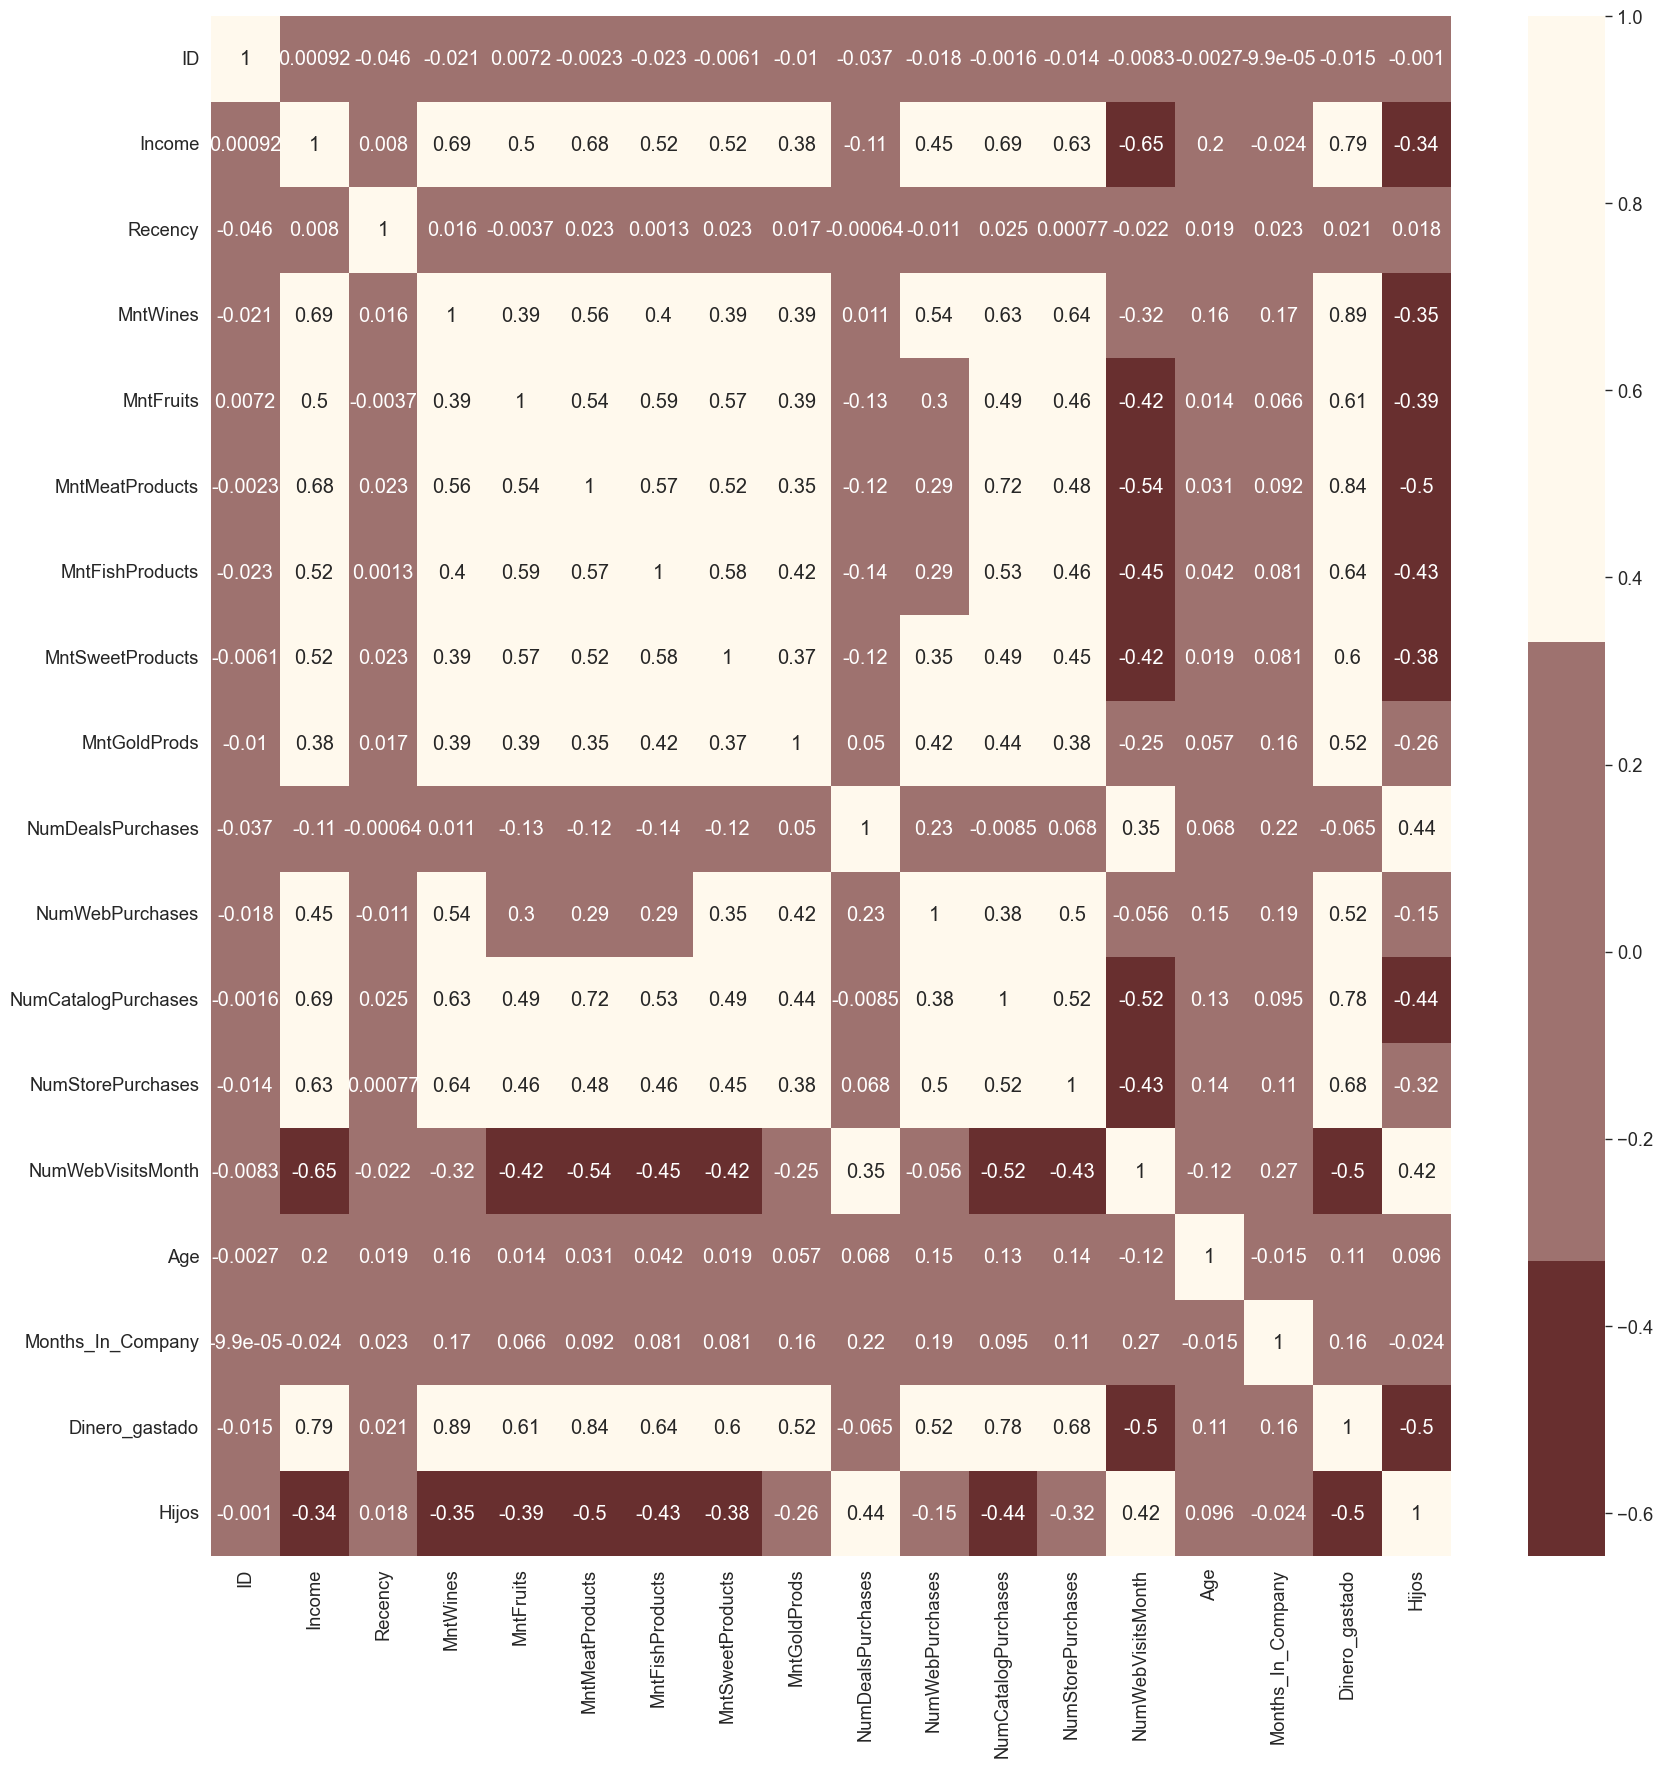

In [113]:
#ploteo la matriz de correlacion
corrmat= df_num.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)


Voy a normalizar los datos numericos para poder trabajar con ellos.

In [114]:
#Dataframe con las variables numericas normalizadas
df_num_norm = (df_num - df_num.mean()) / (df_num.max() - df_num.min())
df_num_norm.head()


,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Months_In_Company,Dinero_gastado,Hijos
0,-0.005809,0.038440,0.089735,0.221616,0.310171,0.219720,0.519165,0.231633,0.121594,0.044931,0.144902,0.262027,-0.138124,0.084056,0.212465,0.417002,0.401196,-0.316935
1,-0.305157,-0.034966,-0.112286,-0.196335,-0.127015,-0.093324,-0.137206,-0.099165,-0.104925,-0.021735,-0.114358,-0.059401,-0.291971,-0.015944,0.266036,-0.332998,-0.229757,0.349732
2,-0.129390,0.122309,-0.233498,0.081629,0.114191,-0.023179,0.283644,-0.023120,-0.005478,-0.088402,0.144902,-0.023687,0.323414,-0.065944,0.069608,-0.041331,0.067466,-0.316935
3,0.052988,-0.157568,-0.233498,-0.196335,-0.111939,-0.085208,-0.106317,-0.091561,-0.107688,-0.021735,-0.077321,-0.095116,-0.138124,0.034056,-0.269678,-0.291331,-0.219439,0.016398
4,-0.023681,0.039405,0.453371,-0.087828,0.084041,-0.028396,0.032679,-0.000306,-0.080064,0.178265,0.033790,0.012027,0.015722,-0.015944,-0.216107,-0.249665,-0.073011,0.016398


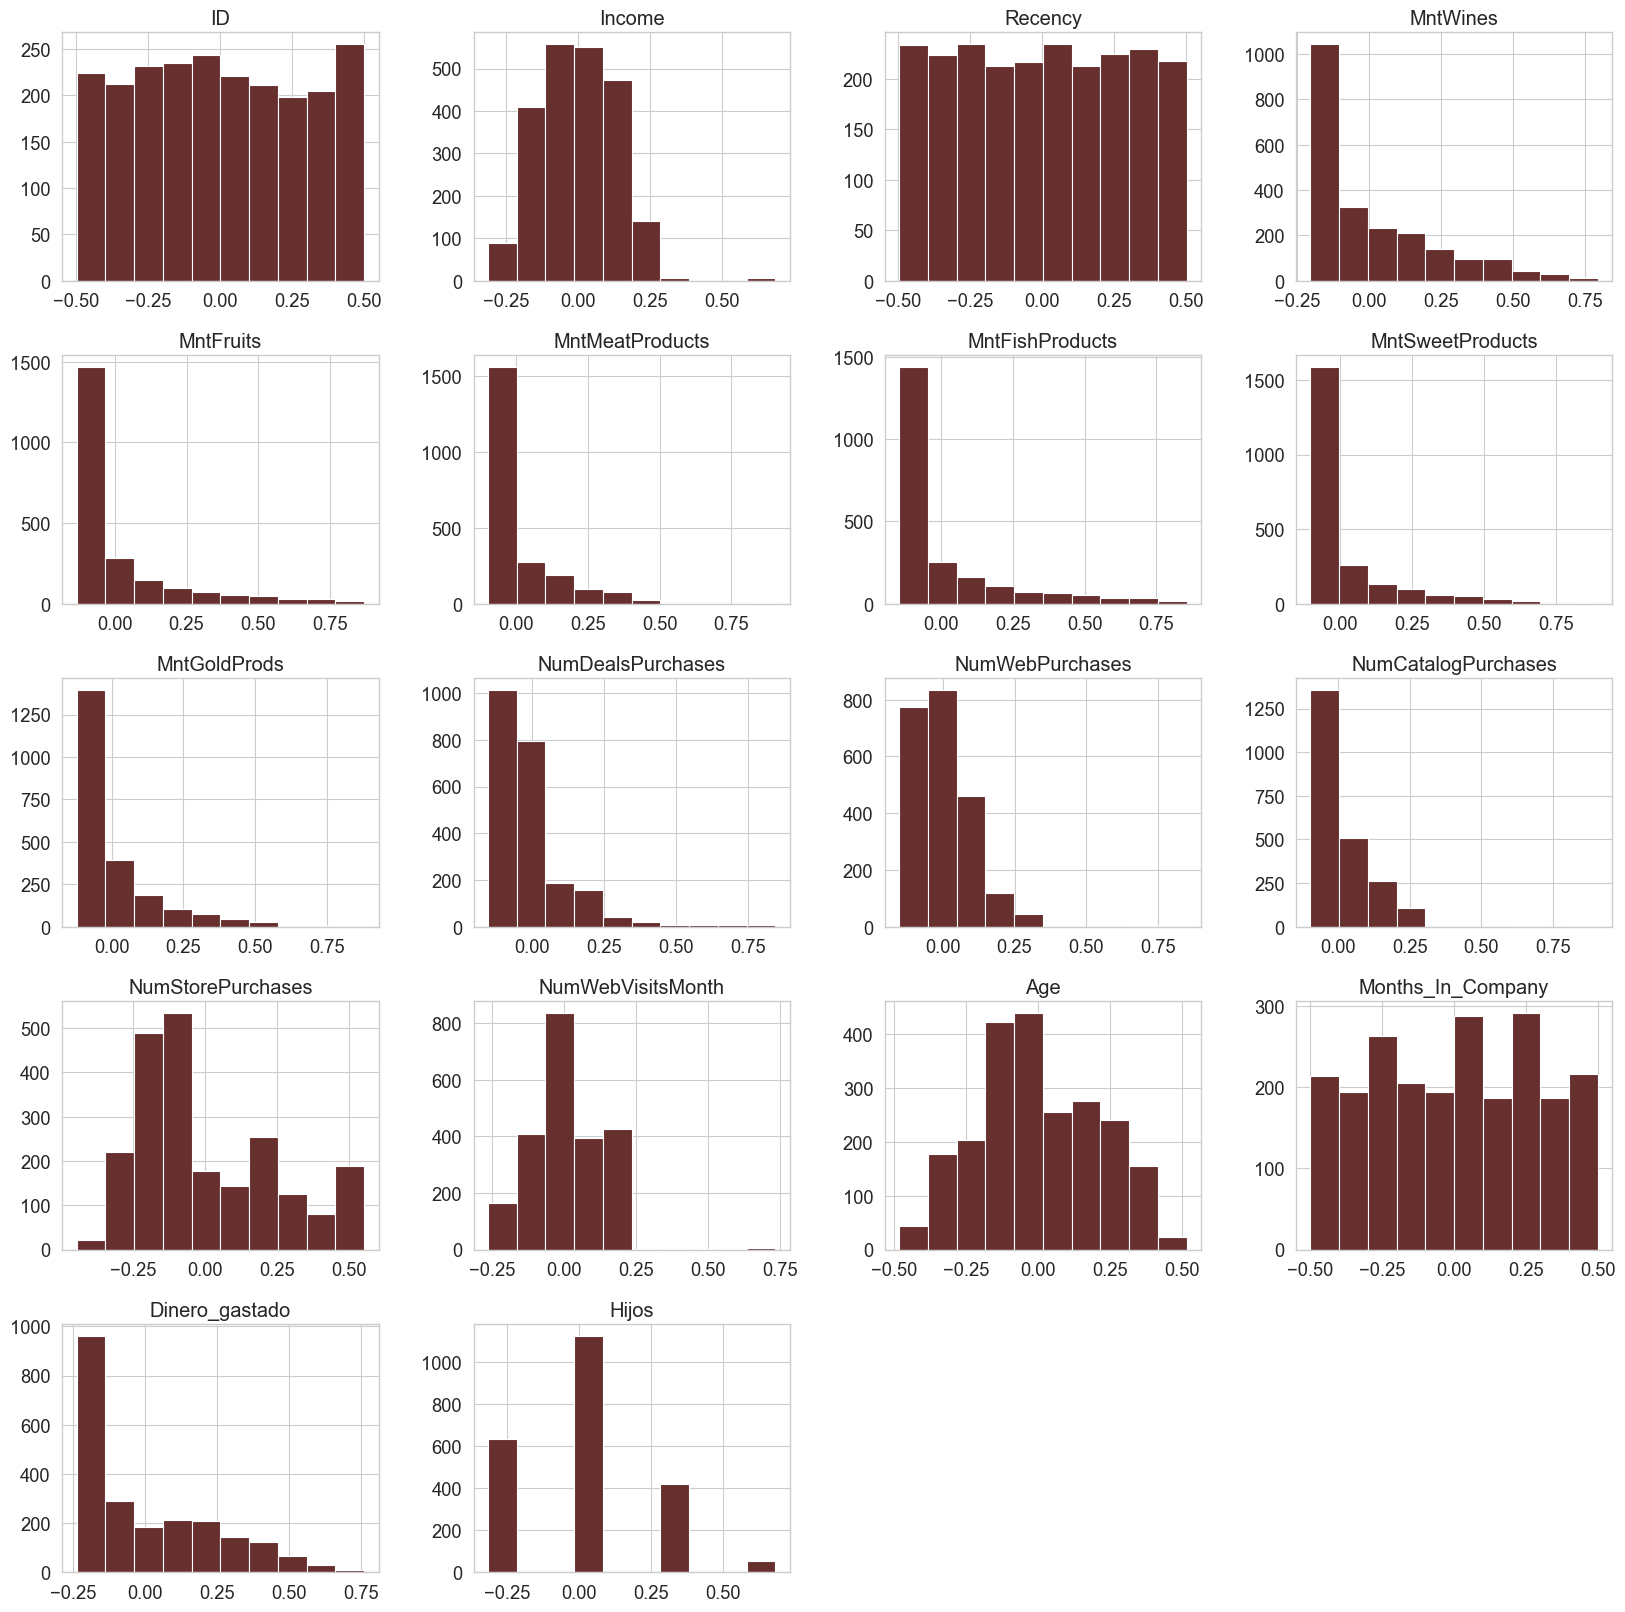

In [115]:
df_num_norm.hist(figsize=(20,20))
plt.show()


In [86]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

NameError: name 'colors' is not defined